In [ ]:
#| include: false
from nbdev.showdoc import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#| include: false
from fastai.vision.all import *
from fastai.callback.all import *
from fasterai.prune.all import *
from fasterai.core.criteria import *
import torch_pruning as tp
from torch_pruning.pruner import function
import torch_pruning as tp

import torch
import torch.nn as nn
import torch.nn.functional as F

Let's try our `PruneCallback` on the `Pets` dataset

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64))

We'll train a vanilla ResNet18 for 5 epochs to have an idea of the expected performance

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.721933,0.757932,0.822733,00:03
1,0.385900,0.288203,0.876861,00:02
2,0.231994,0.253768,0.907984,00:02
3,0.143060,0.197871,0.919486,00:02
4,0.074842,0.203348,0.920839,00:02


In [ ]:
base_macs, base_params = tp.utils.count_ops_and_params(learn.model, torch.randn(1,3,224,224).to(default_device()))

Let's now try adding to remove some filters in our model

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

We'll set the `sparsity` to 50 (i.e. remove 50% of filters), the `context` to global (i.e. we remove filters from anywhere in the network), the `criteria` to large_final (i.e. keep the highest value filters and the `schedule` to one_cycle (i.e. follow the One-Cycle schedule to remove filters along training).

In [ ]:
pr_cb = PruneCallback(sparsity=45, context='global', criteria=large_final, schedule=one_cycle, layer_type=[nn.Conv2d])
learn.fit_one_cycle(10, cbs=pr_cb)

Pruning until a sparsity of [45]%


epoch,train_loss,valid_loss,accuracy,time
0,0.954276,0.466967,0.784168,00:04
1,0.529151,0.317189,0.872124,00:04
2,0.353457,0.278195,0.878890,00:04
3,0.269315,0.354661,0.813261,00:05
4,0.256616,0.253318,0.906631,00:04
5,0.211965,0.234199,0.906631,00:04
6,0.177008,0.189769,0.920162,00:04
7,0.134881,0.183975,0.926252,00:04
8,0.106858,0.178676,0.926928,00:04
9,0.099854,0.175807,0.925575,00:04


Sparsity at the end of epoch 0: [0.45]%
Sparsity at the end of epoch 1: [1.76]%
Sparsity at the end of epoch 2: [6.39]%
Sparsity at the end of epoch 3: [18.07]%
Sparsity at the end of epoch 4: [32.91]%
Sparsity at the end of epoch 5: [41.27]%
Sparsity at the end of epoch 6: [44.03]%
Sparsity at the end of epoch 7: [44.77]%
Sparsity at the end of epoch 8: [44.95]%
Sparsity at the end of epoch 9: [45.0]%
Final Sparsity: [45.0]%


In [ ]:
pruned_macs, pruned_params = tp.utils.count_ops_and_params(learn.model, torch.randn(1,3,224,224).to(default_device()))

We observe that our network has lost 2.5% of accuracy. But how much parameters have we removed and how much compute does that save ?

In [ ]:
print(f'The pruned model has {pruned_macs/base_macs:.2f} the compute of original model')

The pruned model has 0.75 the compute of original model


In [ ]:
print(f'The pruned model has {pruned_params/base_params:.2f} the parameters of original model')

The pruned model has 0.26 the parameters of original model


So at the price of a slight decrease in accuracy, we now have a model that is 5x smaller and requires 1.5x fewer compute.

In [ ]:
from fastai.vision.all import *
from fastai.callback.all import *
from fasterai.prune.all import *
from fasterai.core.criteria import *
import torch_pruning as tp
from torch_pruning.pruner import function
import torch_pruning as tp
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def get_dls(size, bs):
    path = URLs.IMAGENETTE_160
    source = untar_data(path)
    blocks=(ImageBlock, CategoryBlock)
    tfms = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]

    csv_file = 'noisy_imagenette.csv'
    inp = pd.read_csv(source/csv_file)
    dblock = DataBlock(blocks=blocks,
               splitter=ColSplitter(),
               get_x=ColReader('path', pref=source),
               get_y=ColReader(f'noisy_labels_0'),
               item_tfms=tfms,
               batch_tfms=batch_tfms)

    return dblock.dataloaders(inp, path=source, bs=bs)

In [ ]:
model = timm.create_model('resnet18', pretrained=True, no_jit=True).eval()
dls = get_dls(model.default_cfg['input_size'][2], 16)
learn = Learner(dls, model, metrics = [accuracy])

In [ ]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.413728,0.297917,0.908790,00:18
1,0.276229,0.151135,0.952611,00:15


In [ ]:
pr_cb = PruneCallback(sparsity=15, context='global', criteria=large_final, schedule=one_cycle, layer_type=[nn.Conv2d])

learn.fit_one_cycle(5, 1e-4, cbs=pr_cb)

Pruning until a sparsity of [15]%


epoch,train_loss,valid_loss,accuracy,time
0,0.229940,0.149480,0.954140,00:22
1,0.284875,0.233207,0.931720,00:23
2,0.514571,0.384040,0.893503,00:23
3,0.489109,0.383850,0.891720,00:21
4,0.521241,0.386732,0.892739,00:21


Sparsity at the end of epoch 0: [0.59]%
Sparsity at the end of epoch 1: [6.02]%
Sparsity at the end of epoch 2: [13.76]%
Sparsity at the end of epoch 3: [14.92]%
Sparsity at the end of epoch 4: [15.0]%
Final Sparsity: [15.0]%


In [ ]:
learn.model

ResNet(
  (conv1): Conv2d(3, 54, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(54, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(54, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(54, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(54, eps=1e-05, m

In [ ]:
dls = get_dls(128, 64)

In [ ]:
#learn = vision_learner(dls, 'vgg16_bn', metrics = [accuracy])
learn = vision_learner(dls, resnet18, metrics = [accuracy])
learn.unfreeze()

In [ ]:
ignored_layers = []
num_heads = {}

for m in learn.model.modules():
    #if hasattr(m, 'head'): #isinstance(m, nn.Linear) and m.out_features == model.num_classes:
    if isinstance(m, nn.Linear) and m.out_features == dls.c:
        ignored_layers.append(m)
        print("Ignore classifier layer: ", m)

    # Attention layers
    if hasattr(m, 'num_heads'):
        if hasattr(m, 'qkv'):
            num_heads[m.qkv] = m.num_heads
            print("Attention layer: ", m.qkv, m.num_heads)
        elif hasattr(m, 'qkv_proj'):
            num_heads[m.qkv_proj] = m.num_heads

Ignore classifier layer:  Linear(in_features=512, out_features=10, bias=False)


In [ ]:
def onecycle_scheduler(pruning_ratio_dict, steps, start=0, end=1, α=14, β=6):
    return [
        sched_onecycle(start, end, i / float(steps), α, β) * pruning_ratio_dict
        for i in range(steps + 1)
    ]

def sched_onecycle(start, end, pos, α=14, β=6):
    out = (1 + np.exp(-α + β)) / (1 + np.exp((-α * pos) + β))
    return start + (end - start) * out

In [ ]:
class PruneCallback(Callback):
    def __init__(self, pruning_ratio, schedule, criteria, ignored_layers, *args, **kwargs):
        store_attr()
        self.sparsity_levels = []
        self.extra_args = args
        self.extra_kwargs = kwargs

    def before_fit(self):
        n_batches_per_epoch = len(self.learn.dls.train)
        total_training_steps = n_batches_per_epoch * self.learn.n_epoch
        self.total_training_steps = total_training_steps 
        self.example_inputs, _ = self.learn.dls.one_batch()
        self.sparsity_levels = self.schedule(self.pruning_ratio, total_training_steps)

        self.pruner = tp.pruner.MetaPruner(
        self.learn.model,
        example_inputs= torch.randn(self.example_inputs.shape).to('cuda:0'),
        importance=self.criteria,
        pruning_ratio=self.pruning_ratio, 
        ignored_layers=self.ignored_layers,
        iterative_steps= self.total_training_steps, 
        iterative_pruning_ratio_scheduler=self.schedule,
        #global_pruning=self.context, 
        *self.extra_args, 
        **self.extra_kwargs
        )
        
    def before_step(self):
        if self.training: 
            self.pruner.step()
            #for g in self.pruner.step(interactive=True):
            #    g.prune()
            
            for m in learn.model.modules():
                # Attention layers
                if hasattr(m, 'num_heads'):
                    if hasattr(m, 'qkv'):
                        m.num_heads = num_heads[m.qkv]
                        m.head_dim = m.qkv.out_features // (3 * m.num_heads)
                    elif hasattr(m, 'qkv_proj'):
                        m.num_heads = num_heads[m.qqkv_projkv]
                        m.head_dim = m.qkv_proj.out_features // (3 * m.num_heads)

    def after_epoch(self):
        completed_steps = (self.epoch + 1) * len(self.learn.dls.train)
        current_sparsity = self.sparsity_levels[completed_steps - 1]
        print(f'Sparsity at the end of epoch {self.epoch}: {current_sparsity*100:.2f}%')

In [ ]:
learn.fit_one_cycle(5, 1e-3)
pr_cb = PruneCallback(sparsity=25, context='global', criteria=large_final, schedule=one_cycle, layer_type=[nn.Conv2d])
learn.fit_one_cycle(25, 1e-4, cbs=pr_cb)

epoch,train_loss,valid_loss,accuracy,time
0,0.637625,0.910680,0.750318,00:05
1,0.586441,0.592798,0.808917,00:04
2,0.452558,0.374738,0.885605,00:04
3,0.295364,0.246037,0.920255,00:05
4,0.199567,0.208119,0.932229,00:04


Pruning until a sparsity of [25]%


epoch,train_loss,valid_loss,accuracy,time
0,0.170139,0.206207,0.932229,00:05
1,0.179607,0.202834,0.935032,00:05
2,0.160217,0.197775,0.935796,00:06
3,0.142491,0.198794,0.934522,00:05
4,0.148887,0.193478,0.937325,00:05
5,0.139404,0.202506,0.935287,00:05
6,0.107774,0.191174,0.936051,00:05
7,0.124003,0.195926,0.936561,00:05
8,0.104774,0.204832,0.939618,00:05
9,0.104492,0.199253,0.940127,00:06


Sparsity at the end of epoch 0: [0.11]%
Sparsity at the end of epoch 1: [0.19]%
Sparsity at the end of epoch 2: [0.33]%
Sparsity at the end of epoch 3: [0.57]%
Sparsity at the end of epoch 4: [0.98]%
Sparsity at the end of epoch 5: [1.67]%
Sparsity at the end of epoch 6: [2.78]%
Sparsity at the end of epoch 7: [4.49]%
Sparsity at the end of epoch 8: [6.92]%
Sparsity at the end of epoch 9: [10.04]%
Sparsity at the end of epoch 10: [13.5]%
Sparsity at the end of epoch 11: [16.82]%
Sparsity at the end of epoch 12: [19.57]%
Sparsity at the end of epoch 13: [21.58]%
Sparsity at the end of epoch 14: [22.93]%
Sparsity at the end of epoch 15: [23.78]%
Sparsity at the end of epoch 16: [24.29]%
Sparsity at the end of epoch 17: [24.59]%
Sparsity at the end of epoch 18: [24.77]%
Sparsity at the end of epoch 19: [24.87]%
Sparsity at the end of epoch 20: [24.93]%
Sparsity at the end of epoch 21: [24.96]%
Sparsity at the end of epoch 22: [24.98]%
Sparsity at the end of epoch 23: [24.99]%
Sparsity at 

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn = vision_learner(dls, resnet18, metrics = [accuracy])
print(learn.model)
print(sum(p.numel() for p in learn.model.parameters() if p.requires_grad))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn = vision_learner(dls, 'resnet18', metrics = [accuracy])
print(learn.model)
print(sum(p.numel() for p in learn.model.parameters() if p.requires_grad))

Sequential(
  (0): TimmBody(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64

In [ ]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
learn = vision_learner(dls, 'bat_resnext26ts', metrics = [accuracy])
learn.unfreeze()

ignored_layers = []
num_heads = {}

for m in learn.model.modules():
    #if hasattr(m, 'head'): #isinstance(m, nn.Linear) and m.out_features == model.num_classes:
    if isinstance(m, nn.Linear) and m.out_features == dls.c:
        ignored_layers.append(m)
        print("Ignore classifier layer: ", m)

    # Attention layers
    if hasattr(m, 'num_heads'):
        if hasattr(m, 'qkv'):
            num_heads[m.qkv] = m.num_heads
            print("Attention layer: ", m.qkv, m.num_heads)
        elif hasattr(m, 'qkv_proj'):
            num_heads[m.qkv_proj] = m.num_heads

Ignore classifier layer:  Linear(in_features=512, out_features=10, bias=False)


In [ ]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


AssertionError: 

In [ ]:
pr_cb = PruneCallback(pruning_ratio=0.25, schedule=onecycle_scheduler, global_pruning=False, criteria=GroupNormImportance(normalizer=None, target_types=[nn.modules.conv._ConvNd, nn.Linear]), isomorphic=False, ignored_layers=ignored_layers)
learn.fit_one_cycle(25, 1e-4, cbs=pr_cb)

In [ ]:
learn.model

Sequential(
  (0): TimmBody(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(61, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64

In [ ]:
import abc
import torch
import torch.nn as nn

import typing

from torch_pruning import function
from torch_pruning.dependency import Group

class Importance(abc.ABC):
    """ Estimate the importance of a tp.Dependency.Group, and return an 1-D per-channel importance score.

        It should accept a group as inputs, and return a 1-D tensor with the same length as the number of channels.
        All groups must be pruned simultaneously and thus their importance should be accumulated across channel groups.

        Example:
            ```python
            DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224)) 
            group = DG.get_pruning_group( model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9] )    
            scorer = MagnitudeImportance()    
            imp_score = scorer(group)    
            #imp_score is a 1-D tensor with length 3 for channels [2, 6, 9]  
            min_score = imp_score.min() 
            ``` 
    """
    @abc.abstractclassmethod
    def __call__(self, group: Group) -> torch.Tensor: 
        raise NotImplementedError


class GroupNormImportance(Importance):

    def __init__(self, 
                 p: int=2, 
                 group_reduction: str="mean", 
                 normalizer: str='mean', 
                 bias=False,
                 target_types:list=[nn.modules.conv._ConvNd, nn.Linear, nn.modules.batchnorm._BatchNorm, nn.LayerNorm]):
        self.p = p
        self.group_reduction = group_reduction
        self.normalizer = normalizer
        self.target_types = target_types
        self.bias = bias

    def _lamp(self, scores): # Layer-adaptive Sparsity for the Magnitude-based Pruning
        """
        Normalizing scheme for LAMP.
        """
        # sort scores in an ascending order
        sorted_scores,sorted_idx = scores.view(-1).sort(descending=False)
        # compute cumulative sum
        scores_cumsum_temp = sorted_scores.cumsum(dim=0)
        scores_cumsum = torch.zeros(scores_cumsum_temp.shape,device=scores.device)
        scores_cumsum[1:] = scores_cumsum_temp[:len(scores_cumsum_temp)-1]
        # normalize by cumulative sum
        sorted_scores /= (scores.sum() - scores_cumsum)
        # tidy up and output
        new_scores = torch.zeros(scores_cumsum.shape,device=scores.device)
        new_scores[sorted_idx] = sorted_scores
        
        return new_scores.view(scores.shape)
    
    def _normalize(self, group_importance, normalizer):
        if normalizer is None:
            return group_importance
        elif isinstance(normalizer, typing.Callable):
            return normalizer(group_importance)
        elif normalizer == "sum":
            return group_importance / group_importance.sum()
        elif normalizer == "standarization":
            return (group_importance - group_importance.min()) / (group_importance.max() - group_importance.min()+1e-8)
        elif normalizer == "mean":
            return group_importance / group_importance.mean()
        elif normalizer == "max":
            return group_importance / group_importance.max()
        elif normalizer == 'gaussian':
            return (group_importance - group_importance.mean()) / (group_importance.std()+1e-8)
        elif normalizer.startswith('sentinel'): # normalize the score with the k-th smallest element. e.g. sentinel_0.5 means median normalization
            sentinel = float(normalizer.split('_')[1]) * len(group_importance)
            sentinel = torch.argsort(group_importance, dim=0, descending=False)[int(sentinel)]
            return group_importance / (group_importance[sentinel]+1e-8)
        elif normalizer=='lamp':
            return self._lamp(group_importance)
        else:
            raise NotImplementedError

    def _reduce(self, group_imp: typing.List[torch.Tensor], group_idxs: typing.List[typing.List[int]]):
        if len(group_imp) == 0: return group_imp
        if self.group_reduction == 'prod':
            reduced_imp = torch.ones_like(group_imp[0])
        elif self.group_reduction == 'max':
            reduced_imp = torch.ones_like(group_imp[0]) * -99999
        else:
            reduced_imp = torch.zeros_like(group_imp[0])

        for i, (imp, root_idxs) in enumerate(zip(group_imp, group_idxs)):
            imp = imp.to(reduced_imp.device)
            if self.group_reduction == "sum" or self.group_reduction == "mean":
                reduced_imp.scatter_add_(0, torch.tensor(root_idxs, device=imp.device), imp) # accumulated importance
            elif self.group_reduction == "max": # keep the max importance
                selected_imp = torch.index_select(reduced_imp, 0, torch.tensor(root_idxs, device=imp.device))
                selected_imp = torch.maximum(input=selected_imp, other=imp)
                reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), selected_imp)
            elif self.group_reduction == "prod": # product of importance
                selected_imp = torch.index_select(reduced_imp, 0, torch.tensor(root_idxs, device=imp.device))
                torch.mul(selected_imp, imp, out=selected_imp)
                reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), selected_imp)
            elif self.group_reduction == 'first':
                if i == 0:
                    reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), imp)
            elif self.group_reduction == 'gate':
                if i == len(group_imp)-1:
                    reduced_imp.scatter_(0, torch.tensor(root_idxs, device=imp.device), imp)
            elif self.group_reduction is None:
                reduced_imp = torch.stack(group_imp, dim=0) # no reduction
            else:
                raise NotImplementedError
        
        if self.group_reduction == "mean":
            reduced_imp /= len(group_imp)
        return reduced_imp
    
    @torch.no_grad()
    def __call__(self, group: Group):
        group_imp = []
        group_idxs = []
        # Iterate over all groups and estimate group importance
        for i, (dep, idxs) in enumerate(group):
            layer = dep.layer
            prune_fn = dep.pruning_fn
            root_idxs = group[i].root_idxs
            if not isinstance(layer, tuple(self.target_types)):
                continue
            ####################
            # Conv/Linear Output
            ####################
            if prune_fn in [
                function.prune_conv_out_channels,
                function.prune_linear_out_channels,
            ]:
                if hasattr(layer, "transposed") and layer.transposed:
                    w = layer.weight.data.transpose(1, 0)[idxs].flatten(1)
                else:
                    w = layer.weight.data[idxs].flatten(1)
                #local_imp = w.abs().pow(self.p).sum(1)
                local_imp = w.abs().pow(self.p).mean(1)
                group_imp.append(local_imp)
                group_idxs.append(root_idxs)

                if self.bias and layer.bias is not None:
                    local_imp = layer.bias.data[idxs].abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

            ####################
            # Conv/Linear Input
            ####################
            elif prune_fn in [
                function.prune_conv_in_channels,
                function.prune_linear_in_channels,
            ]:
                if hasattr(layer, "transposed") and layer.transposed:
                    w = (layer.weight.data).flatten(1)
                else:
                    w = (layer.weight.data).transpose(0, 1).flatten(1)
                #local_imp = w.abs().pow(self.p).sum(1)
                local_imp = w.abs().pow(self.p).mean(1)

                # repeat importance for group convolutions
                if prune_fn == function.prune_conv_in_channels and layer.groups != layer.in_channels and layer.groups != 1:
                    local_imp = local_imp.repeat(layer.groups)
                
                local_imp = local_imp[idxs]
                group_imp.append(local_imp)
                group_idxs.append(root_idxs)

            ####################
            # BatchNorm
            ####################
            elif prune_fn == function.prune_batchnorm_out_channels:
                # regularize BN
                if layer.affine:
                    w = layer.weight.data[idxs]
                    local_imp = w.abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

                    if self.bias and layer.bias is not None:
                        local_imp = layer.bias.data[idxs].abs().pow(self.p)
                        group_imp.append(local_imp)
                        group_idxs.append(root_idxs)
            ####################
            # LayerNorm
            ####################
            elif prune_fn == function.prune_layernorm_out_channels:

                if layer.elementwise_affine:
                    w = layer.weight.data[idxs]
                    local_imp = w.abs().pow(self.p)
                    group_imp.append(local_imp)
                    group_idxs.append(root_idxs)

                    if self.bias and layer.bias is not None:
                        local_imp = layer.bias.data[idxs].abs().pow(self.p)
                        group_imp.append(local_imp)
                        group_idxs.append(root_idxs)

        if len(group_imp) == 0: # skip groups without parameterized layers
            return None

        group_imp = self._reduce(group_imp, group_idxs)
        group_imp = self._normalize(group_imp, self.normalizer)
        return group_imp


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 19, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(19, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(5, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(19, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
# True
learn.model

Sequential(
  (0): TimmBody(
    (model): ResNet(
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(32, 1

In [ ]:
pr_cb = PruneCallback(pruning_ratio=0.25, schedule=onecycle_scheduler, context=False, criteria=tp.importance.GroupNormImportance(), num_heads=num_heads, ignored_layers=ignored_layers)

learn.fit_one_cycle(25, 1e-4, cbs=pr_cb)

/home/HubensN/miniconda3/envs/fasterai/lib/python3.9/site-packages/torch_pruning/dependency.py:697: UserWarning: Unwrapped parameters detected: ['blocks.1.gamma_1', 'blocks.1.gamma_2', 'blocks.2.gamma_1', 'blocks.3.attn.v_bias', 'blocks.4.attn.q_bias', 'blocks.5.gamma_2', 'blocks.7.attn.relative_position_bias_table', 'blocks.10.attn.v_bias', 'blocks.0.gamma_1', 'blocks.2.attn.v_bias', 'blocks.4.gamma_1', 'blocks.6.attn.v_bias', 'blocks.7.attn.q_bias', 'blocks.8.gamma_1', 'blocks.6.gamma_1', 'blocks.6.gamma_2', 'blocks.7.gamma_1', 'blocks.8.attn.relative_position_bias_table', 'blocks.9.attn.relative_position_bias_table', 'blocks.11.attn.relative_position_bias_table', 'blocks.0.attn.q_bias', 'blocks.5.gamma_1', 'blocks.7.attn.v_bias', 'blocks.8.attn.q_bias', 'blocks.9.attn.q_bias', 'blocks.11.attn.q_bias', 'blocks.0.attn.relative_position_bias_table', 'blocks.1.attn.relative_position_bias_table', 'blocks.7.gamma_2', 'blocks.8.gamma_2', 'blocks.9.gamma_1', 'blocks.10.gamma_2', 'cls_token'

RuntimeError: Exception occured in `PruneCallback` when calling event `before_fit`:
	mat1 and mat2 shapes cannot be multiplied (12608x767 and 768x2304)

In [ ]:
ignored_layers = []
num_heads = {}
pruning_ratio_dict = {}
import random

population = [
    [0.265625,0.234375,0.265625,0.265625,0.93359375,0.328125,0.2265625,0.58984375,0.54296875,0.701171875,0.919921875,0.04296875,0.796875,0.240966796875,0.07763671875],
    [0.96875,0.578125,0.3515625,0.6328125,0.7578125,0.7109375,0.8984375,0.533203125,0.0703125,0.697265625,0.451171875,0.626953125,0.935546875,0.294921875,0.5244140625],
    [0.25,0.421875,0.171875,0.4921875,0.71875,0.51953125,0.71875,0.876953125,0.896484375,0.626953125,0.646484375,0.490234375,0.65234375,0.599609375,0.0341796875],
    [0.015625,0.015625,0.078125,0.4375,0.59375,0.6953125,0.73828125,0.611328125,0.787109375,0.76171875,0.25,0.427734375,0.154296875,0.592529296875,0.298583984375]
]

for m in model.modules():
    if isinstance(m, nn.Linear) and m.out_features == model.num_classes:
        ignored_layers.append(m)
        print("Ignore classifier layer: ", m)

    # Attention layers
    if hasattr(m, 'num_heads'):
        if hasattr(m, 'qkv'):
            num_heads[m.qkv] = m.num_heads
            print("Attention layer: ", m.qkv, m.num_heads)
        elif hasattr(m, 'qkv_proj'):
            num_heads[m.qkv_proj] = m.num_heads


print("========Before pruning========")

pruner = tp.pruner.MetaPruner(
                model, 
                example_inputs, 
                global_pruning=args.global_pruning, # If False, a uniform pruning ratio will be assigned to different layers.
                importance=imp, # importance criterion for parameter selection
                iterative_steps=1, # the number of iterations to achieve target pruning ratio
                pruning_ratio=args.pruning_ratio, # target pruning ratio
                num_heads=num_heads,
                ignored_layers=ignored_layers,
            )
for g in pruner.step(interactive=True):
    g.prune()

for m in model.modules():
    # Attention layers
    if hasattr(m, 'num_heads'):
        if hasattr(m, 'qkv'):
            m.num_heads = num_heads[m.qkv]
            m.head_dim = m.qkv.out_features // (3 * m.num_heads)
        elif hasattr(m, 'qkv_proj'):
            m.num_heads = num_heads[m.qqkv_projkv]
            m.head_dim = m.qkv_proj.out_features // (3 * m.num_heads)

In [ ]:
dls = get_dls(224, 64)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In [ ]:
class PruneCallback(Callback):
    def __init__(self, pruning_ratio, schedule, criteria, context, ignored_layers, *args, **kwargs):
        store_attr()

    def before_fit(self, *args, **kwargs):
        n_batches_per_epoch = len(self.learn.dls.train)
        total_training_steps = n_batches_per_epoch * self.learn.n_epoch
        self.total_training_steps = total_training_steps 
        self.example_inputs, _ = self.learn.dls.one_batch()

        self.pruner = tp.pruner.MetaPruner(
        self.learn.model,
        example_inputs= torch.randn(self.example_inputs.shape).to('cuda:0'),
        importance=self.criteria,
        pruning_ratio=self.pruning_ratio, 
        ignored_layers=self.ignored_layers,
        iterative_steps= self.total_training_steps, 
        iterative_pruning_ratio_scheduler=self.schedule,
        global_pruning=self.context, 
        *args, 
        **kwargs
        )
        
    def before_step(self):
        if self.training: 
            #self.pruner.step()
            for g in self.pruner.step(interactive=True):
                g.prune()
            
            for m in learn.model.modules():
                # Attention layers
                if hasattr(m, 'num_heads'):
                    if hasattr(m, 'qkv'):
                        m.num_heads = num_heads[m.qkv]
                        m.head_dim = m.qkv.out_features // (3 * m.num_heads)
                    elif hasattr(m, 'qkv_proj'):
                        m.num_heads = num_heads[m.qqkv_projkv]
                        m.head_dim = m.qkv_proj.out_features // (3 * m.num_heads)

    def after_epoch(self):
        print(f'Sparsity at the end of epoch {self.epoch}: {self.pruning_ratio}%')

In [ ]:
ignored_layers = []
for m in learn.model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == dls.c:
        ignored_layers.append(m)

pr_cb = PruneCallback(pruning_ratio=0.25, schedule=onecycle_scheduler, context=True, criteria=tp.importance.GroupNormImportance(p=2), isomorphic=True, ignored_layers=ignored_layers)

learn.fit_one_cycle(25, 1e-4, cbs=pr_cb)

TypeError: __init__() got an unexpected keyword argument 'pruning_ratio'

In [ ]:
learn.model

ResNet(
  (conv1): Conv2d(3, 62, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(62, 57, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(57, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(62, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def onecycle_scheduler(pruning_ratio_dict, steps, start=0, end=1, α=14, β=6):
    return [
        sched_onecycle(start, end, i / float(steps), α, β) * pruning_ratio_dict
        for i in range(steps + 1)
    ]

def sched_onecycle(start, end, pos, α=14, β=6):
    out = (1 + np.exp(-α + β)) / (1 + np.exp((-α * pos) + β))
    return start + (end - start) * out

# Example usage
pruning_ratios = onecycle_scheduler(0.5, 100)  # Example with 50% pruning over 100 steps
print(pruning_ratios)

[0.0012367263146483558, 0.0014220454859807212, 0.001635043092733776, 0.0018798237783997401, 0.002161091482266488, 0.0024842339131953793, 0.002855417953294845, 0.0032816970845535704, 0.003771131928771016, 0.004332924939350293, 0.0049775701622554805, 0.0057170187662244935, 0.006564860695442109, 0.007536522279025944, 0.008649478888826547, 0.009923480707588726, 0.011380788280236587, 0.013046412689388978, 0.014948352833891222, 0.01711781930913656, 0.019589430716528734, 0.022401363825174766, 0.0255954338906404, 0.029217075721353132, 0.03331519004087204, 0.03794181380283069, 0.04315156813196123, 0.04900083458504804, 0.05554661091892243, 0.06284500333774128, 0.07094932531574505, 0.07990779556150135, 0.08976086102011731, 0.10053821537890886, 0.1122556378082479, 0.12491183640307571, 0.138485538581236, 0.1529331160864169, 0.16818705284793903, 0.1841555477189028, 0.20072348258984823, 0.21775487822530787, 0.23509681386491593, 0.25258462095559103, 0.2700480029107912, 0.28731761040396375, 0.304231539

[<matplotlib.lines.Line2D>]

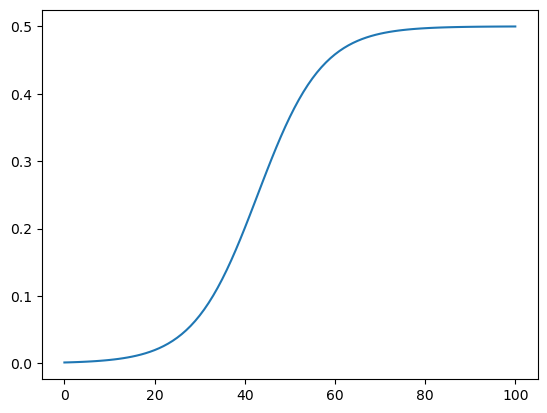

In [ ]:
plt.plot(pruning_ratios)

In [ ]:
def linear_scheduler(pruning_ratio_dict, steps):
    return [((i) / float(steps)) * pruning_ratio_dict for i in range(steps+1)]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(44, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(44, 89, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(89, 89, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(89, 179, kern

In [ ]:
learn = Learner(dls, resnet18(dls.c), metrics=accuracy)


ignored_layers = []
for m in learn.model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == dls.c:
        ignored_layers.append(m) # DO NOT prune the final classifier!

pr_cb = PruneCallback(sparsity=0.5, context="False", criteria=tp.importance.GroupNormImportance(p=2), schedule=tp.scheduler.linear_scheduler, ignored_layers=ignored_layers)

learn.unfreeze()
learn.fit_one_cycle(3, cbs=pr_cb)

<torch_pruning.pruner.importance.GroupNormImportance object>
Pruning until a sparsity of 0.5%


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: running_mean should contain 63 elements not 64

In [ ]:
learn.model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)